## Import Data

In [1]:
import sys
from data import *

import sklearn as sk
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.model_selection import *

from imblearn.over_sampling import SMOTE,ADASYN
from collections import Counter

Using TensorFlow backend.


In [2]:
x = completeX()
x_scaled = standardX()
y = labeledY()
biny = binaryY()
df = completeDS()
biny = biny.astype(np.int8)

## Oversampling

In [3]:
Counter(y)

Counter({'N': 151, 'R': 47})

In [4]:
def process_oversampling(mode, xx, binyy):
    # if mode is 1, then we preprocess the training dataset with ADASYN
    # if mode is 2, then we preprocess the training dataset with SMOTE
    # else we preprocess the training dataset with RandomOverSampler
    if mode == 1:
        osp = ADASYN(random_state=42)
    elif mode == 2:
        osp = SMOTE(random_state=42)
    else:
        osp = RandomOverSampler(random_state=42)
    x_pre, y_pre = osp.fit_sample(xx, binyy)
    return x_pre, y_pre

## Split Dataset

In [5]:
def get_features(mode):
    total = ['recur_time', 'radius_mean', 'texture_mean',
       'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'concave points_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se',
       'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
       'concave points_se', 'symmetry_se', 'fractal_dimension_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'compactness_worst', 'concavity_worst',
       'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst',
       'tumor_size', 'lymph_node_status', 'radius_distance',
       'texture_distance', 'perimeter_distance',
       'area_distance', 'smoothness_distance',
       'compactness_distance', 'concavity_distance',
       'concave points_distance', 'symmetry_distance',
       'fractal_dimension_distance']
    cut = ['recur_time', 'perimeter_se','perimeter_distance',
       'area_distance', 
       'area_se', 'radius_se', 'texture_se', 'smoothness_se', 'compactness_se', 'concavity_se',
       'concave points_se', 'symmetry_se', 'fractal_dimension_se',
       'tumor_size', 'lymph_node_status', 'radius_distance',
       'texture_distance',  'smoothness_distance',
       'compactness_distance', 'concavity_distance',
       'concave points_distance', 'symmetry_distance',
       'fractal_dimension_distance']
    partial = ['recur_time', 'radius_se', 'texture_se', 'smoothness_se', 'compactness_se', 'concavity_se',
       'concave points_se', 'symmetry_se', 'fractal_dimension_se',
       'tumor_size', 'lymph_node_status', 'radius_distance',
       'texture_distance',  'smoothness_distance',
       'compactness_distance', 'concavity_distance',
       'concave points_distance', 'symmetry_distance',
       'fractal_dimension_distance'] 
    if mode == 0:
        return total
    elif mode == 1:
        return cut
    elif mode == 2:
        return partial

In [6]:
def return_cross_val(ds, os, ftr):
    # If ds is equal to 0, that means we need the original dataset
    # If ds is equal to 1, that means we need the Standardized dataset
    y_cross_val = biny
    if ds == 0:
        x_cross_val = x
    elif ds == 1:
        x_cross_val = x_scaled
        
    features = get_features(ftr)
    # If os is equal to 0, that means we need the original dataset
    # If os is equal to others, that means we need to preprocess the dataset
    if os == 0:
        x_train, x_test, y_train, y_test = train_test_split(x_cross_val[features], biny, test_size=0.33, random_state=42)
    else:
        x_imb, y_imb = process_oversampling(os, x_cross_val, biny)
        x_train, x_test, y_train, y_test = train_test_split(x_imb[features], y_imb, test_size=0.33, random_state=42)
    return x_train, x_test, y_train, y_test

## Fitting & Validating

In [7]:
def cross_validation(clf, labels):
    scorers = ['accuracy', 'precision', 'f1']
    acc = cross_val_score(clf, x_train[labels], y_train, cv=10, scoring='accuracy')
    pre = cross_val_score(clf, x_train[labels], y_train, cv=10, scoring='precision')
    f1 = cross_val_score(clf, x_train[labels], y_train, cv=10, scoring='f1')
    ranges = list(range(1, 11))
    plt.plot(ranges, acc, label='acc')
    plt.plot(ranges, pre, label='pre')
    plt.plot(ranges, f1, label='f1')
    plt.xlabel('K fold')
    plt.ylabel('Performance')
    plt.legend(loc='best')
    plt.show()

In [8]:
def find_best_clf(model, params):
    # Here we use a parameter dict to find the best param for classifier
    clf = GridSearchCV(model, params, scoring='recall')
    clf.fit(x_train, y_train)
    print(clf.__class__.__name__)
    
    # Print out the best params list
    print("Best params: \n{0}\n".format(clf.best_params_))
    
    # Pring out the best estimator
    best_clf = clf.best_estimator_
    print("Best estimator is {}".format(best_clf))
    
    # Return the best classifier
    return best_clf

In [38]:
def predict(classifier, params=0):
    # If params is 0, we use the classifier directly
    # If params is not 0, we might find the best classifier by Grid Search from the param dict
    if params == 0:    
        clf = classifier.fit(x_train, y_train)
        print(clf.__class__.__name__)
    else:
        clf = find_best_clf(classifier, params)
    
    # Show out the ROC curve
#     show_roc(clf)
    
    # Predict the validation dataset
    y_pred = clf.predict(x_test)
    
    # Print out the classification report
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Recall: ", recall_score(y_test, y_pred))
    print("\n 1. confusion matrix\n", confusion_matrix(y_test, y_pred))
    print("\n 2. classification report\n", classification_report(y_test, y_pred))

    # We might compare the classification report with macro scores
    res_DT = []
    res_DT.append([accuracy_score(y_test, y_pred),
                   precision_score(y_test, y_pred, average = "macro"),
                   recall_score(y_test, y_pred, average = "macro"),
                   f1_score(y_test, y_pred, average = "macro")])

    print("3. performance measurements for classification model")

    pd.DataFrame(res_DT, columns = ["Accuracy", "Precision", "Recall", "F1-score"], index=['Logistic Regression'])
    
    # As we don't know the param list from the classifier invoked directly
    # We show out the param list as follow
    if params==0:
        print("The Default params is {}".format(clf.get_params))
    print('--------------------------------------------------------\n')
    return clf

In [24]:
def show_roc(clf):
    y_pred = clf.predict(x_test)
    if clf.__class__.__name__ == 'SVC':
        # SVC does not prediction probability but it can calculate 
        # the distance between samples and hyperplane
        y_prob = clf.decision_function(x_test)
    else:
        y_prob = clf.predict_proba(x_test)[:, 1]
    
    draw_roc(y_pred, "Prediction",clf.__class__.__name__)
    draw_roc(y_prob, "Probability",clf.__class__.__name__)

In [25]:
def draw_roc(y_score, mode, clf_name):
    
    fpr, tpr, threshold = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    # 调节图片大小与清晰度
    plt.rcParams['savefig.dpi'] = 300  
    plt.rcParams['figure.dpi'] = 300
    
    # 画ROC曲线
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0,1],[0,1], 'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(clf_name+"_ROC")
    plt.legend(loc = 'best')
    plt.savefig("./ROC/"+clf_name+"_ROC_"+mode+".png")
    plt.show()

## Finding Best Combination of algorithms preprocessing the dataset

In [26]:
def find_preprocessing_algo(ds=2):
    ds_dict = {
        0:'All_Features',
        1:'Cut_Features',
        2:'Partial_Features'
    }
    os_dict = {
        0:'RandomOverSampler',
        1:'ADASYN',
        2:'SMOTE',
    }
    lst = [2, 4, 6, 8, 10]
    for os in range(1,3):
        # We want clear graphs
        plt.rcParams['savefig.dpi'] = 100  
        plt.rcParams['figure.dpi'] = 100  
        
        # We store the evaluation data in the following list
        accuracy_list = []
        recall_list = []
        precision_list = []
        f1_list = []

        # Identify the model
        name = ds_dict[ds]+' '+os_dict[os]
        print(name)

        # Get Data and do cross validation
        x_train, x_test, y_train, y_test = return_cross_val(ds=0, os=os, ftr=2)

        # Calculate the evaluation data by Logistic Regression
        for i in lst:
            clf = DecisionTreeClassifier(min_samples_split=i)
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_test)

            accuracy_list.append(accuracy_score(y_test, y_pred))
            precision_list.append(precision_score(y_test, y_pred))
            recall_list.append(recall_score(y_test, y_pred))
            f1_list.append(f1_score(y_test, y_pred))

        # Plot 4 evaluation data line and save the graphs
        plt.plot(lst, accuracy_list, 'r', label='Accuracy')
        plt.plot(lst, recall_list, 'b', label='Recall')
        plt.plot(lst, precision_list, 'g', label='Precision')
        plt.plot(lst, f1_list, 'y', label='F1')
        plt.title(name)
        plt.xlabel('min_samples_split')
        plt.ylabel('Measure')
        plt.ylim(0.0, 1.0)
        plt.legend(loc='best')
        plt.savefig('./LR_total_cut_scaled/'+ds_dict[ds]+'_'+os_dict[os]+'.png')
        plt.show()

Partial_Features ADASYN


FileNotFoundError: [Errno 2] No such file or directory: './LR_total_cut_scaled/Partial_Features_ADASYN.png'

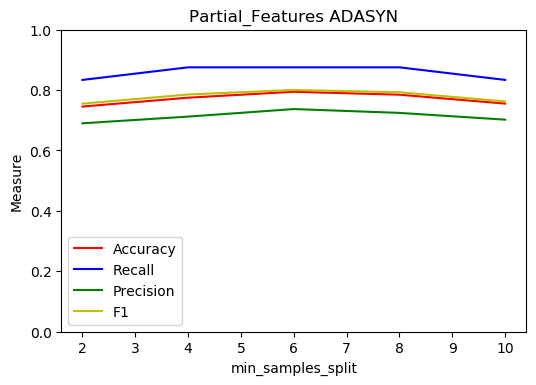

In [27]:
find_preprocessing_algo()

# The Best Model

- Best Features and Method for Oversampling
- Return Cross Validation Datasets
- Find Best Parameters for Classifiers Repectively

In [28]:
fts = ['recur_time',  'radius_se', 'texture_se', 'smoothness_se', 'compactness_se', 'concavity_se',
       'concave points_se', 'symmetry_se', 'fractal_dimension_se',
       'tumor_size', 'lymph_node_status', 'radius_distance',
       'texture_distance',  'smoothness_distance',
       'compactness_distance', 'concavity_distance',
       'concave points_distance', 'symmetry_distance',
       'fractal_dimension_distance']

#### Oversampling

In [29]:
def oversp(xx, binyy):
    osp = ADASYN(random_state=42)
    x_pre, y_pre = osp.fit_sample(xx, binyy)
    print(Counter(y_pre))
    return x_pre, y_pre

#### Cross Validation

In [30]:
def cross_vld():
    # Cross Validation
    # there 3 options for oversampling and 2 options for mode
    x_cross_val = x
    y_cross_val = biny
    x_train, x_test, y_train, y_test = train_test_split(x_cross_val[fts], y_cross_val, test_size=0.1, random_state=42)
    x_train, y_train = oversp(x_train, y_train)
    return x_train, x_test, y_train, y_test

In [31]:
x_train, x_test, y_train, y_test = cross_vld()

Counter({1: 139, 0: 135})


#### Best Parameters

In [32]:
clf_dict = {
    'knn':  KNeighborsClassifier(n_neighbors=3),
    'dt':   DecisionTreeClassifier(random_state=42, criterion='entropy',splitter='random'),
    'svc':  svm.SVC(random_state=42),
    'mlp':  MLPClassifier(random_state=42),
    'lr':   LogisticRegression(random_state=42),
    'rf':   RandomForestClassifier(random_state=42, n_estimators=100),
    'et':   ExtraTreesClassifier(random_state=42, n_estimators=10)
}
model_dict = {}

In [33]:
def modeling():
    for abbr, classifier in clf_dict.items():
        model = predict(classifier)
        model_dict[abbr] = model

In [54]:
def find_best_ftr():
    feature_list = list(x_train.columns)
    
    rst = model_dict['et']
    importances = list(rst.feature_importances_)
    feature_importances = [(features, round(importance, 2)) for features, importance in zip(feature_list, importances)]

    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
    
    sns.set(style="darkgrid")
    plt.rcParams['savefig.dpi'] = 300  
    plt.rcParams['figure.dpi'] = 300
    fig, ax = plt.subplots(figsize=(20,10))
    output_corr = pd.DataFrame(feature_importances, columns=["Features", "Importance"])
    sns.barplot(x="Features", y="Importance", data=output_corr, ax=ax)
    plt.xticks(rotation=-90)
    plt.show()

In [39]:
modeling()

KNeighborsClassifier
Accuracy:  0.7
Recall:  0.75

 1. confusion matrix
 [[11  5]
 [ 1  3]]

 2. classification report
               precision    recall  f1-score   support

           0       0.92      0.69      0.79        16
           1       0.38      0.75      0.50         4

    accuracy                           0.70        20
   macro avg       0.65      0.72      0.64        20
weighted avg       0.81      0.70      0.73        20

3. performance measurements for classification model
The Default params is <bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')>
--------------------------------------------------------

DecisionTreeClassifier
Accuracy:  0.8
Recall:  0.25

 1. confusion matrix
 [[15  1]
 [ 3  1]]

 2. classification report
               precision    recall  f1-score   support

           0 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


MLPClassifier
Accuracy:  0.8
Recall:  1.0

 1. confusion matrix
 [[12  4]
 [ 0  4]]

 2. classification report
               precision    recall  f1-score   support

           0       1.00      0.75      0.86        16
           1       0.50      1.00      0.67         4

    accuracy                           0.80        20
   macro avg       0.75      0.88      0.76        20
weighted avg       0.90      0.80      0.82        20

3. performance measurements for classification model
The Default params is <bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=

Variable: recur_time           Importance: 0.16
Variable: lymph_node_status    Importance: 0.07
Variable: radius_distance      Importance: 0.07
Variable: radius_se            Importance: 0.06
Variable: texture_distance     Importance: 0.06
Variable: texture_se           Importance: 0.05
Variable: concave points_se    Importance: 0.05
Variable: tumor_size           Importance: 0.05
Variable: smoothness_distance  Importance: 0.05
Variable: smoothness_se        Importance: 0.04
Variable: compactness_se       Importance: 0.04
Variable: concavity_se         Importance: 0.04
Variable: symmetry_se          Importance: 0.04
Variable: fractal_dimension_se Importance: 0.04
Variable: compactness_distance Importance: 0.04
Variable: concave points_distance Importance: 0.04
Variable: symmetry_distance    Importance: 0.04
Variable: fractal_dimension_distance Importance: 0.04
Variable: concavity_distance   Importance: 0.03


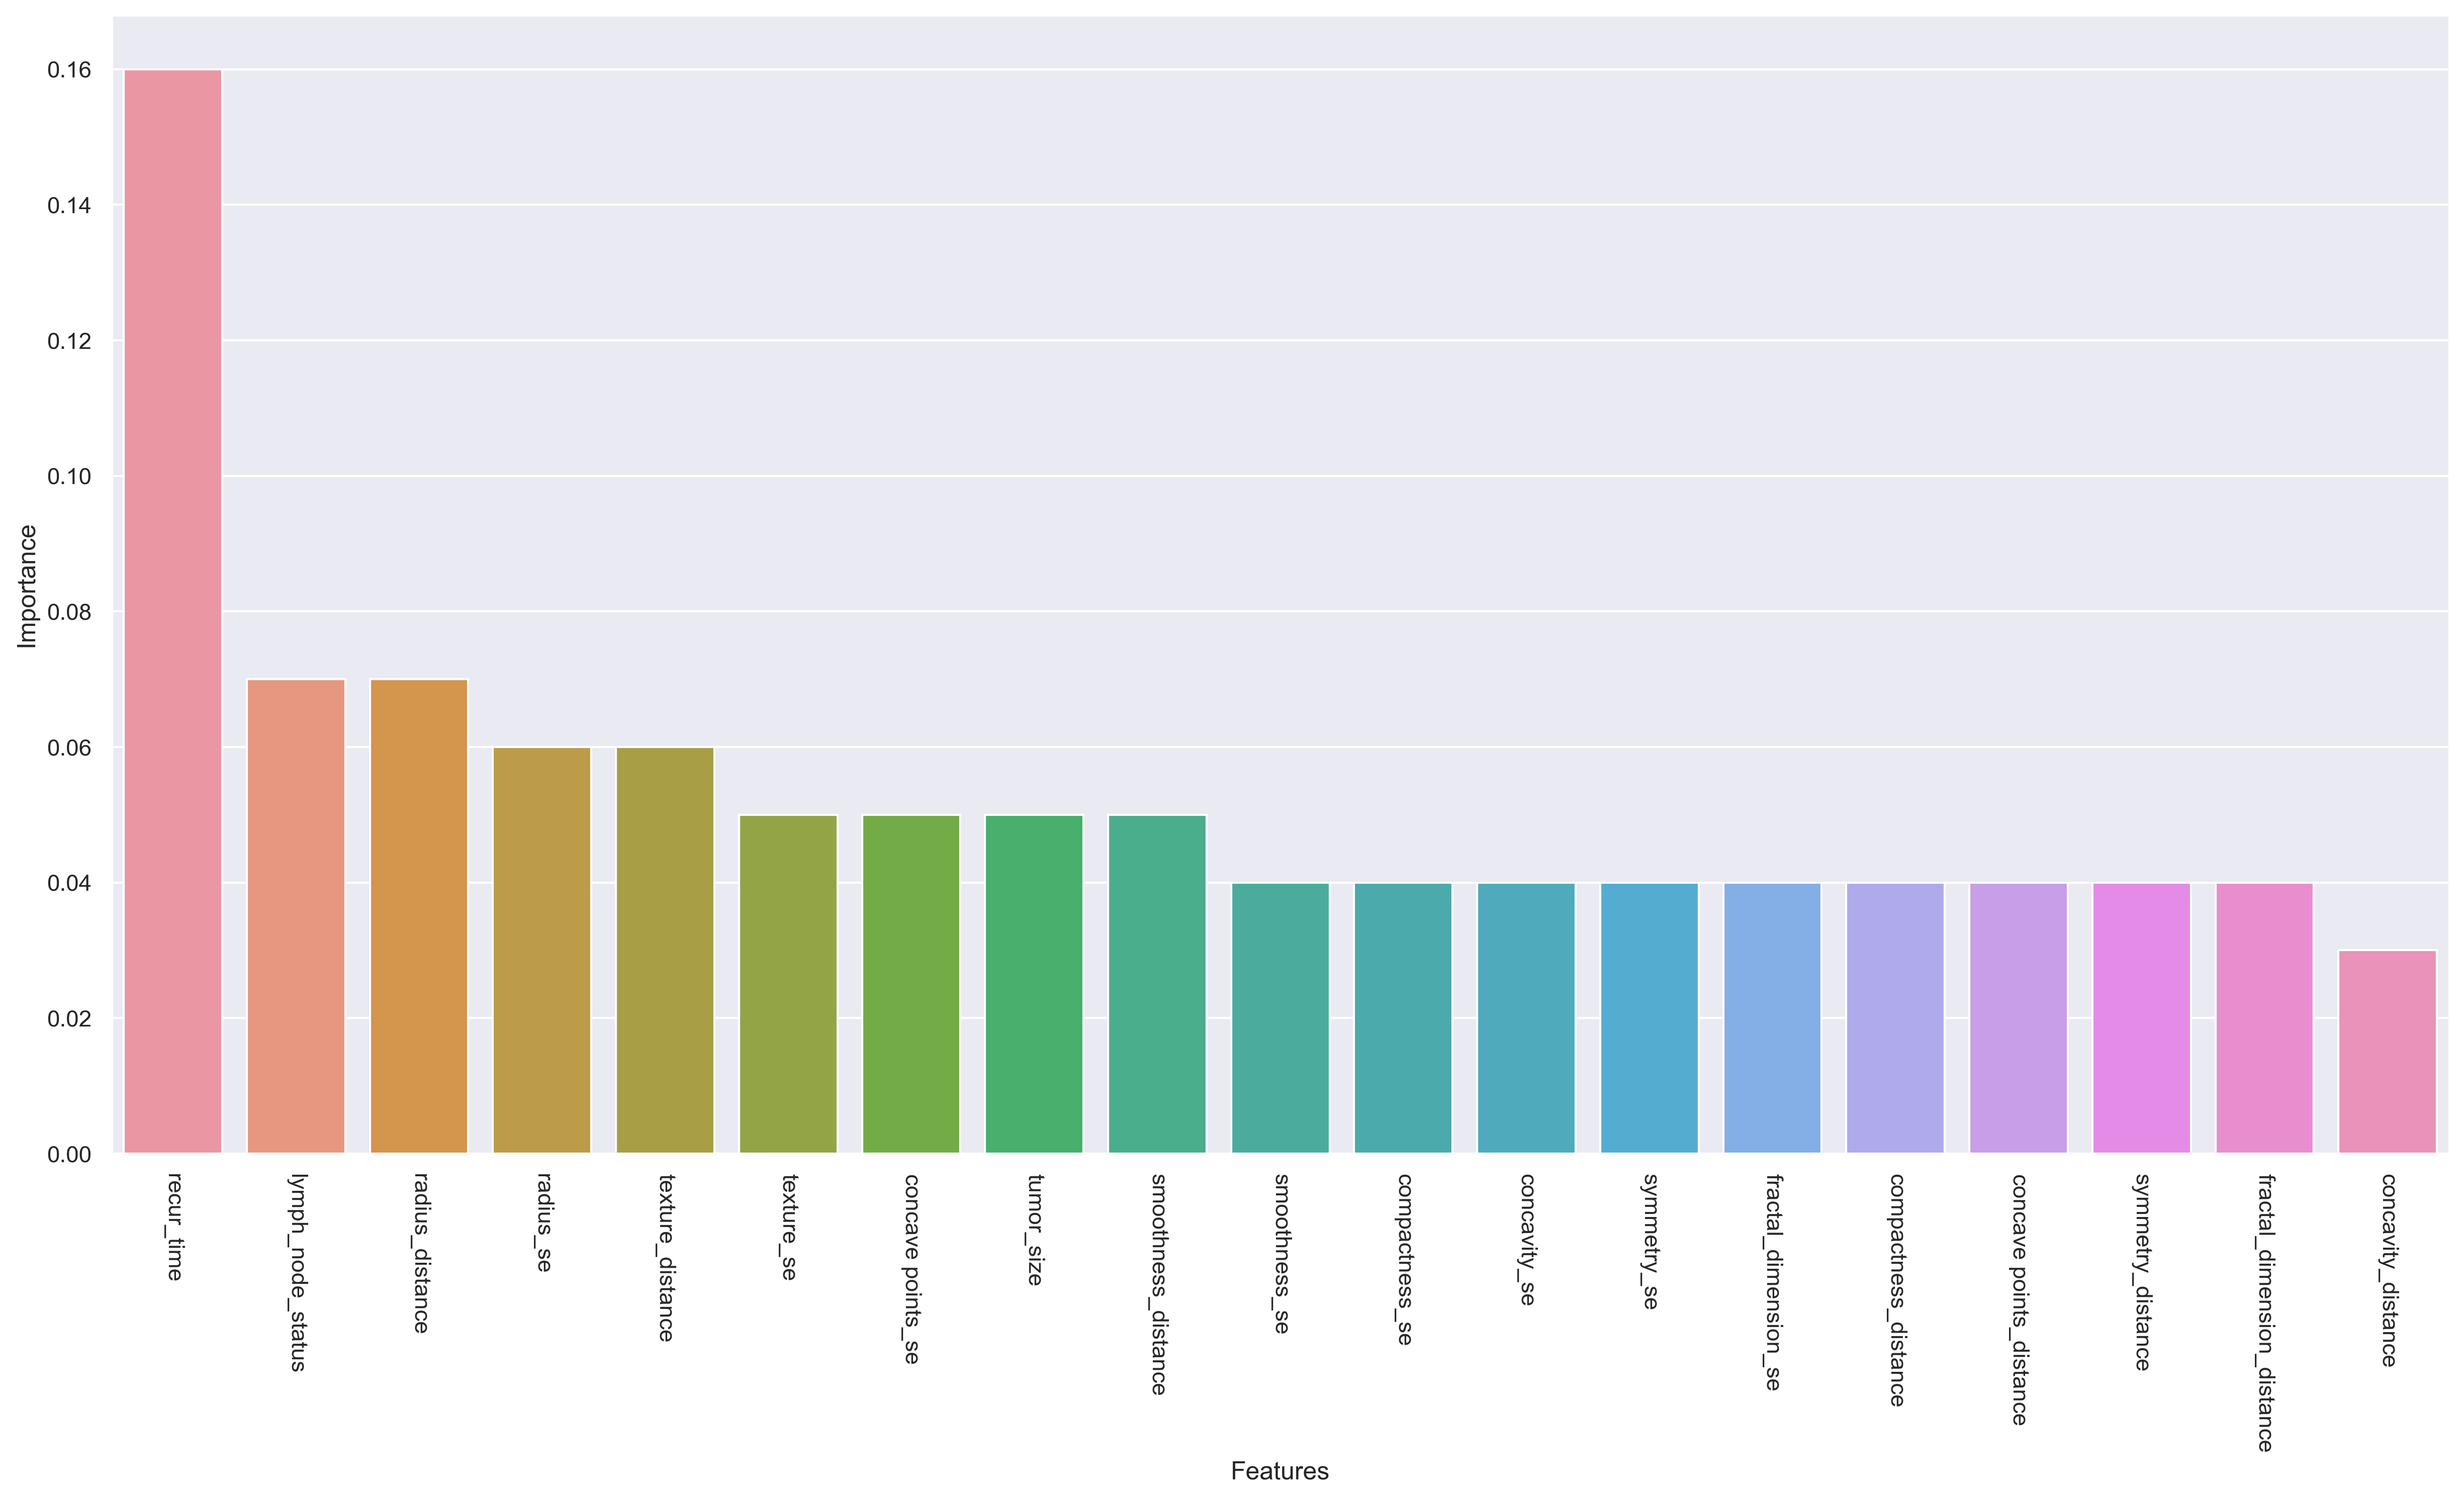

In [55]:
find_best_ftr()